## NpyDataset - Example
This notebook shows the functionalities of the NpyDataset and how to use them. 

This dataset is designed to be used with multiple npy cubes at the same time as a source or with npy files (see the save and load examples below) created by this dataset. 

Args:
- **`data_src`** (str): A list of dictionaries containing the paths to the seismic data and labels 
    - [{'train': cube_path, 'label': labels_path, order : ('x', 'y', 'z')}, ...]
- **`dt_transformations`** (List[Callable]): A list of transformations to apply to the data
- **`lb_transformations`** (List[Callable]): A list of transformations to apply to the labels
- **`mode`** (str): The mode to use for the dataset (default: 'windowed', 'original')
    - 'windowed': Return windowed slices of the data 
    - 'original': Return full slices of the data
- **`dtype`** (np.dtype): The datatype to use for the data   (default: np.float32)
- **`ltype`** (np.dtype): The datatype to use for the labels (default: np.float32)
- **`norm`**: (bool): Whether to normalize the data when loading (default: False)
    - **windowed mode**, the data is normalized window by window
    - **original mode**, the data is normalized slice by slice 
- Only in 'windowed' mode: 
    - **`window_x`**(int): The width of the windowed slice (default: 128)
    - **`window_y`** (int): The height of the windowed slice (default: 128)
    - **`stride`** (int): The stride to use when creating windowed slices (default: 30)

In [1]:
import numpy as np
from NpyDataset import NpyDataset
import numpy.testing as npt
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
def plot_slice(dataset, idx):
    data, label = dataset[idx]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    ax1.imshow(data, cmap='seismic')
    ax1.set_title(f"Data Slice {idx}")
    ax2.imshow(label, cmap='viridis')
    ax2.set_title(f"Label Slice {idx}")
    plt.show()

### Initialize the Dataset

In [3]:
seam_path = {'train' : 'data/SEAM/seismic_train.npy', 'label' : 'data/SEAM/labels.npy', 'order' : ('z', 'x', 'y')}
f3_path = {'train' : 'data/F3/seismic_entire_volume.npy', 'label' : 'data/F3/labels_entire_volume.npy', 'order' : ('x', 'y', 'z')}
paths = [seam_path, f3_path]

In [4]:
_dataset = NpyDataset(paths)

In [5]:
# _dataset.window_sizes[0]

In [6]:
# len(_dataset)

In [7]:
# _dataset[0][0].shape

In [8]:
# loading data manually to compare 
seam_cube = np.load(seam_path['train'], mmap_mode='r')
seam_labels = np.load(seam_path['label'], mmap_mode='r')
f3_cube = np.load(f3_path['train'], mmap_mode='r')
f3_labels = np.load(f3_path['label'], mmap_mode='r')

In [9]:
seam_cube.shape, f3_cube.shape
# Calculating window sizes: {'s1': (30, 17), 's2': (30, 23)}, {'s1': (6, 27), 's2': (6, 17)}, =============
# window_x=64, window_y=64, stride=32

((1006, 782, 590), (601, 901, 255))

In [10]:
f3_cube = np.transpose(f3_cube, tuple(('x', 'y', 'z').index(dim) for dim in ('z', 'x', 'y'))).astype(np.float32)
f3_labels = np.transpose(f3_labels, tuple(('x', 'y', 'z').index(dim) for dim in ('z', 'x', 'y')) ).astype(np.float32)
f3_cube.shape, seam_cube.shape

((255, 601, 901), (1006, 782, 590))

### Testing indexing

In [11]:
npt.assert_array_equal(_dataset[0][0], seam_cube[:, 0, :])
npt.assert_array_equal(_dataset[0][1], seam_labels[:, 0, :])

npt.assert_array_equal(_dataset[1][0], seam_cube[:, 1, :])
npt.assert_array_equal(_dataset[1][1], seam_labels[:, 1, :])

npt.assert_array_equal(_dataset[781][0], seam_cube[:, 781, :])
npt.assert_array_equal(_dataset[781][1], seam_labels[:, 781, :])

npt.assert_array_equal(_dataset[782][0], seam_cube[:, :, 0])
npt.assert_array_equal(_dataset[782][1], seam_labels[:, :, 0])

In [12]:
npt.assert_array_equal(_dataset[1372][0], f3_cube[:, 0, :])
npt.assert_array_equal(_dataset[1372][1], f3_labels[:, 0, :])

npt.assert_array_equal(_dataset[1372 + 550][0], f3_cube[:, 0 + 550, :])
npt.assert_array_equal(_dataset[1372 + 550][1], f3_labels[:, 0 + 550, :])

npt.assert_array_equal(_dataset[1372 + 600][0], f3_cube[:, 0 + 600, :])
npt.assert_array_equal(_dataset[1372 + 600][1], f3_labels[:, 0 + 600, :])

npt.assert_array_equal(_dataset[1372 + 800][0], f3_cube[:, :, 199])
npt.assert_array_equal(_dataset[1372 + 800][1], f3_labels[:, :, 199])

In [13]:
# _dataset[0][0].shape,_dataset[5][0].shape ,_dataset[1372 + 0][0].shape ,_dataset[1372 + 800][0].shape

### Plotting some slices

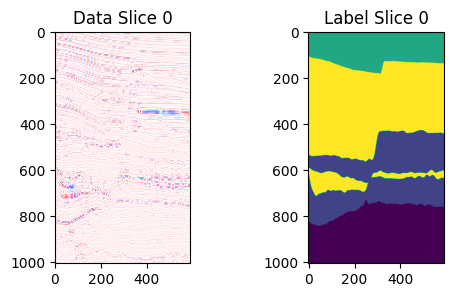

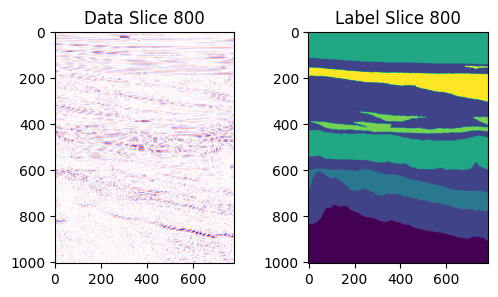

In [14]:
# ilines from seam
plot_slice (_dataset, 0)
# xlines from seam
plot_slice (_dataset, 800)


In [15]:
len(_dataset)

2874

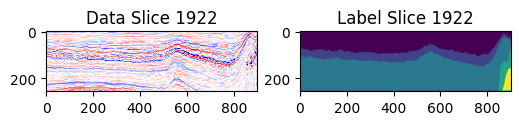

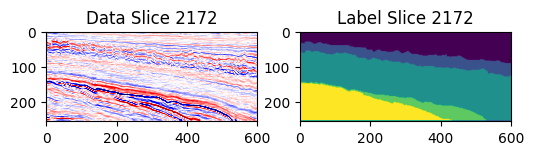

In [16]:
# iline from f3
plot_slice (_dataset, 1372 + 550)
# xline from f3
plot_slice (_dataset, 1372 + 800)

### Testing traces mode 

In [17]:
seam_cube.shape

(1006, 782, 590)

In [18]:
f3_cube.shape, seam_cube.shape

((255, 601, 901), (1006, 782, 590))

In [19]:
traces_dataset = NpyDataset(paths, mode='traces')

In [20]:
npt.assert_array_equal(traces_dataset[0][0], seam_cube[:, 0, 0])
npt.assert_array_equal(traces_dataset[591][0], seam_cube[:, 1, 1])
npt.assert_array_equal(traces_dataset[1002880][0], f3_cube[:, 600, 900])


In [21]:
seam_cube[:, 1, 1]

memmap([332.4878  , 223.74115 ,   2.475792, ..., -50.526688, -43.833603,
          5.505224], dtype=float32)

In [22]:
traces_dataset[591][0]

array([332.4878  , 223.74115 ,   2.475792, ..., -50.526688, -43.833603,
         5.505224], dtype=float32)

### Testing Windowed mode 

In [23]:
# testing windowing mode
windowed_dataset = NpyDataset(paths, mode='windowed', window_x=128, window_y=128, stride=7)

In [24]:
print(f"Windowed dataset length: {len(windowed_dataset)}")

Windowed dataset length: 16021205


In [25]:
# Test getting a windowed slice
windowed_slice_data, windowed_slice_label = windowed_dataset[0]
print(f"Windowed slice shape: {windowed_slice_data.shape}")

Windowed slice shape: (128, 128)


In [26]:
def test_windowed_slice(dataset, idx, expected_shape):
    data, label = dataset[idx]
    assert data.shape == expected_shape, f"Expected shape {expected_shape}, got {data.shape}"
    assert label.shape == expected_shape, f"Expected shape {expected_shape}, got {label.shape}"
    # print(f"Test passed for index {idx}")

In [27]:
# Test a slice from the SEAM dataset
test_windowed_slice(windowed_dataset, 0, (128, 128))

In [28]:
# Calculate the number of windows in the SEAM dataset
seam_windows = (windowed_dataset.window_sizes[0]['s1'][0] * windowed_dataset.window_sizes[0]['s1'][1] * windowed_dataset._get_shape(0, "x") + 
                windowed_dataset.window_sizes[0]['s2'][0] * windowed_dataset.window_sizes[0]['s2'][1] * windowed_dataset._get_shape(0, "y"))

seam_windows

13589604

In [29]:
# Test a slice from the F3 dataset
test_windowed_slice(windowed_dataset, seam_windows, (128, 128))

In [30]:
# Test the last slice
test_windowed_slice(windowed_dataset, len(windowed_dataset) - 1, (128, 128))

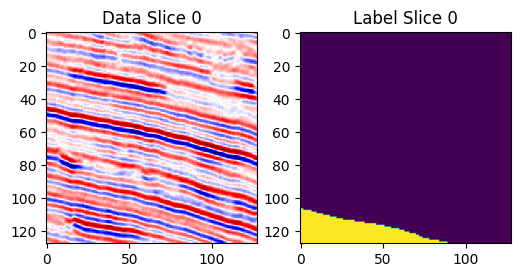

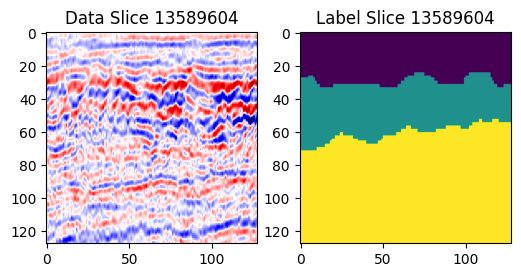

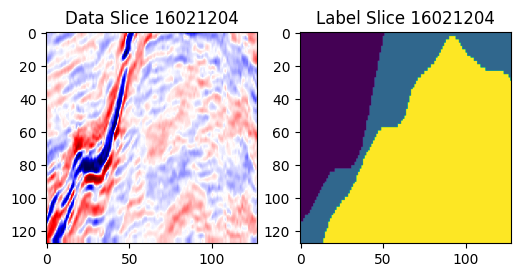

(None, None, None)

In [31]:
plot_slice(windowed_dataset, 0), plot_slice(windowed_dataset, seam_windows), plot_slice(windowed_dataset, len(windowed_dataset) - 1)

### Test consistency between windowed and original mode

In [32]:
def test_windowed_consistency(windowed_dataset, original_dataset, windowed_idx, original_idx, w_idx):
    windowed_data, windowed_label = windowed_dataset[windowed_idx]
    original_data, original_label = original_dataset[original_idx]
    
    window_x, window_y = windowed_dataset.window_x, windowed_dataset.window_y
    stride = windowed_dataset.stride
    
    start_x = (w_idx // (original_data.shape[1] // stride)) * stride
    start_y = (w_idx % (original_data.shape[1] // stride)) * stride
    
    # print ("start_x, start_y", start_x, start_y)
    # print (original_data.shape)
    original_window = original_data[start_x:start_x+window_x, start_y:start_y+window_y]
    original_window_label = original_label[start_x:start_x+window_x, start_y:start_y+window_y]

    
    np.testing.assert_array_almost_equal(windowed_data, original_window)
    np.testing.assert_array_almost_equal(windowed_label, original_window_label)
    print(f"Consistency test passed for window index {windowed_idx} and original index {original_idx} and window number: {w_idx}")

In [33]:
seam_cube.shape

(1006, 782, 590)

In [34]:
# Test consistency for a few slices
test_windowed_consistency(windowed_dataset, _dataset, 0, 0, 0)
test_windowed_consistency(windowed_dataset, _dataset, 10, 0, 10)
test_windowed_consistency(windowed_dataset, _dataset, seam_windows + 5, 1372, 5)

Consistency test passed for window index 0 and original index 0 and window number: 0
Consistency test passed for window index 10 and original index 0 and window number: 10
Consistency test passed for window index 13589609 and original index 1372 and window number: 5


In [35]:
# clean up
del _dataset
del windowed_dataset
del seam_cube
del seam_labels
del f3_cube
del f3_labels
del traces_dataset

### Dataloader Example

In [36]:
def test_seismic_dataset(mode, norm_dt = False, norm_dl = False, batch_size=12, window_x=128, window_y=128, stride=50):
    print(f"Testing SeismicDataset in {mode} mode")
    
    # Initialize dataset
    dataset = NpyDataset(paths, mode=mode, norm = norm_dt, window_x=window_x, window_y=window_y, stride=stride)
    
    # Create collate function
    collate_fn = dataset.create_windowed_collate_fn(dataset, norm_flag= norm_dl, window_x=window_x, window_y=window_y, stride=stride)
    
    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    
    # Get a batch of data
    data_batch, label_batch = next(iter(dataloader))
    
    print(f"Batch shape: {data_batch.shape}")
    
    if mode != 'traces':
        # Plot samples
        fig, axs = plt.subplots(2, 6, figsize=(9, 4))
        
        for i in range(6):
            row = i // 3
            col = (i % 3) * 2
            
            # Data sample
            axs[row, col].imshow(data_batch[i], cmap='seismic')
            axs[row, col].set_title(f"Data {i+1}")
            axs[row, col].axis('off')
            
            # Label sample
            axs[row, col+1].imshow(label_batch[i], cmap='viridis')
            axs[row, col+1].set_title(f"Label {i+1}")
            axs[row, col+1].axis('off')
    else:
        # Plot traces samples
        fig, axs = plt.subplots(2, 6, figsize=(9, 4))
        
        for i in range(6):
            row = i // 3
            col = (i % 3) * 2
            
            # Data sample
            axs[row, col].plot(data_batch[i])
            axs[row, col].set_title(f"Traces {i+1}")
            axs[row, col].axis('off')
            
            # Label sample
            axs[row, col+1].plot(label_batch[i])
            axs[row, col+1].set_title(f"Label {i+1}")
            axs[row, col+1].axis('off')

    plt.tight_layout()
    plt.show()


    plt.tight_layout()
    plt.show()
    
    return dataset, dataloader

Testing SeismicDataset in slice mode
Batch shape: torch.Size([2328, 128, 128])


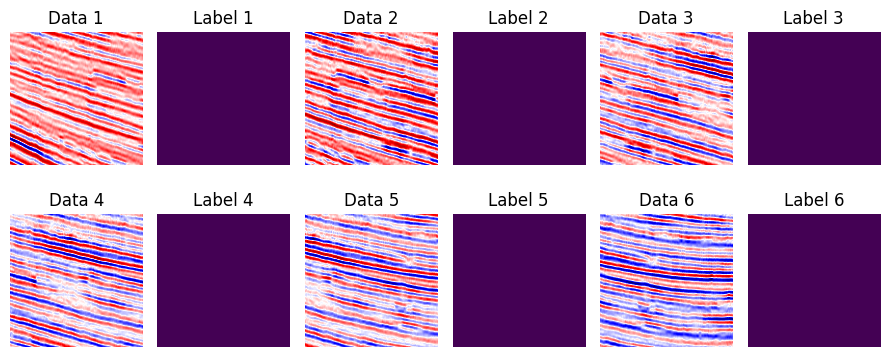

<Figure size 640x480 with 0 Axes>

  2%|▏         | 5/240 [00:05<04:33,  1.17s/it]


In [37]:
#  Test original mode
original_dataset, original_dataloader = test_seismic_dataset('slice')

print("\n" + "="*50 + "\n")

# test loading all data from data loader - use tqdm to show progress
for i, (data, label) in enumerate(tqdm(original_dataloader)):
    if (i == 5): # break after 15 batches - original dataset is too large
        break

Testing SeismicDataset in windowed mode
Batch shape: torch.Size([12, 128, 128])


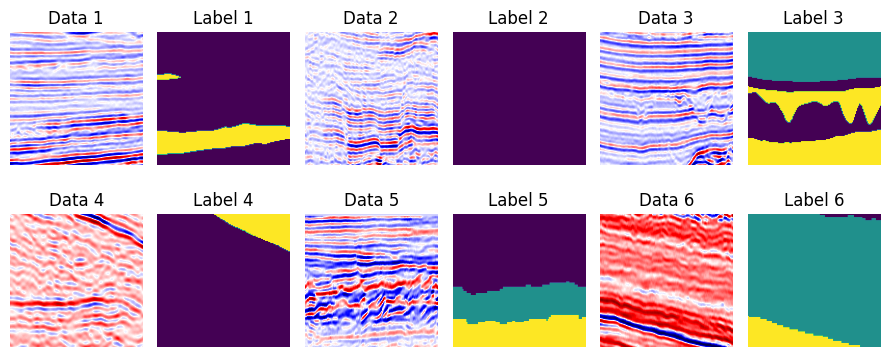

<Figure size 640x480 with 0 Axes>

5it [00:04,  1.05it/s]


In [38]:
# Test windowed mode
windowed_dataset, windowed_dataloader = test_seismic_dataset('windowed')

print("\n" + "="*50 + "\n")

# test dataloader - loading all data
for i, (data, label) in tqdm(enumerate(windowed_dataloader)):
    if (i == 5): # break after 5 batches
        break

Testing SeismicDataset in traces mode
Batch shape: torch.Size([126, 128])


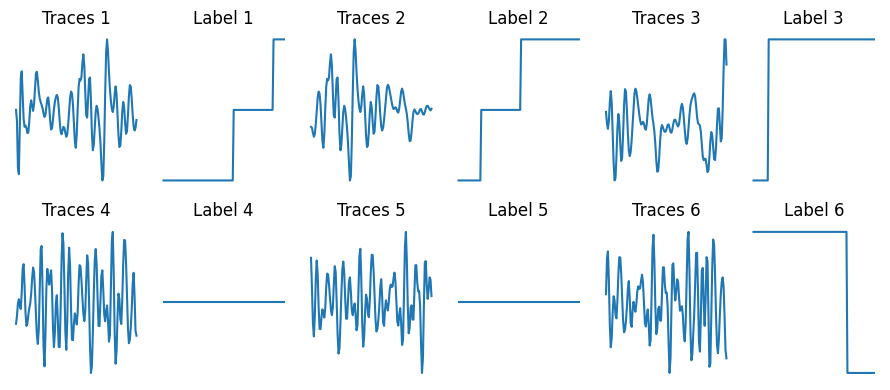

<Figure size 640x480 with 0 Axes>

5it [00:04,  1.13it/s]


In [39]:
traces_dataset, traces_dataloader = test_seismic_dataset('traces')

print("\n" + "="*50 + "\n")

# test dataloader - loading all data
for i, (data, label) in tqdm(enumerate(windowed_dataloader)):
    if (i == 5): # break after 5 batches
        break

In [40]:
del original_dataset, original_dataloader, windowed_dataset, windowed_dataloader

### Testing normalization

In [41]:
def is_normalized(dt):
    
    _mean = dt.mean()
    _std = dt.std()
    b1 = np.isclose(_mean, 0, atol=1e-2)
    b2 = np.isclose(_std, 1, atol=1e-2)
    # print (f"mean: {_mean}, std: {_std}")
    return (b1 and b2)

In [42]:
def test_seismic_dataset_norm(mode, norm_ds = False, norm_dl = False, batch_size=6, window_x=64, window_y=64, stride=32):
    print(f"Testing SeismicDataset in {mode} mode")
    
    # Initialize dataset
    dataset = NpyDataset(paths, mode=mode, norm = norm_ds, window_x=window_x, window_y=window_y, stride=stride)
    
    print (dataset[0][0].shape)
    
    # Create collate function
    collate_fn = dataset.create_windowed_collate_fn(dataset, norm_flag= norm_dl, window_x=window_x, window_y=window_y, stride=stride)
    
    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    
    # # Get a batch of data
    data_batch, label_batch = next(iter(dataloader))
        
    # Plot samples
    fig, axs = plt.subplots(2, 6, figsize=(9, 4))
    
    if mode != 'traces':
    
        for i in range(6):
            row = i // 3
            col = (i % 3) * 2
            
            # Data sample
            axs[row, col].imshow(data_batch[i], cmap='seismic')
            axs[row, col].set_title(f"Data {i+1}")
            axs[row, col].axis('off')
            
            # Label sample
            axs[row, col+1].imshow(label_batch[i], cmap='viridis')
            axs[row, col+1].set_title(f"Label {i+1}")
            axs[row, col+1].axis('off')

        plt.tight_layout()
        plt.show()
    else: 
        
        for i in range(6):
            row = i // 3
            col = (i % 3) * 2
            
            # Data sample
            axs[row, col].plot(data_batch[i])
            axs[row, col].set_title(f"Traces {i+1}")
            axs[row, col].axis('off')
            
            # Label sample
            axs[row, col+1].plot(label_batch[i])
            axs[row, col+1].set_title(f"Label {i+1}")
            axs[row, col+1].axis('off')
    
    # # check if a sample is normalized
    dt = data_batch[5]
    assert (is_normalized(dt) == (norm_ds or norm_dl)), f"Normalization error"
    
    dt = dataset[2][0]
    assert is_normalized(dt) == norm_ds, f"Normalization error"
    
    return dataset, dataloader

Testing SeismicDataset in slice mode
(1006, 590)


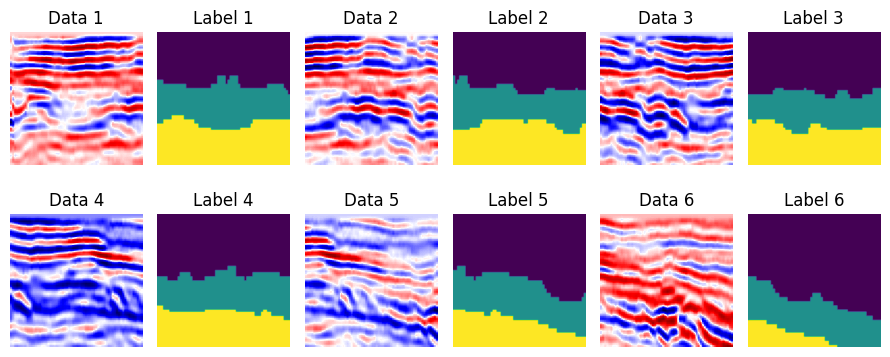

In [44]:
# dataloader normalized only
original_dataset, original_dataloader = test_seismic_dataset_norm('slice', norm_dl=True)

In [45]:
original_dataset, original_dataset[2][0]

(<NpyDataset.NpyDataset at 0x1528c9a00>,
 memmap([[ 333.0957  ,  314.72192 ,  353.82007 , ..., -171.38478 ,
          -209.5706  , -268.65015 ],
         [ 129.67458 ,  229.34486 ,  301.4402  , ...,  164.20673 ,
           194.56178 ,  172.26697 ],
         [ -84.59677 ,   33.223938,   69.17766 , ...,  227.70984 ,
           290.45923 ,  291.44873 ],
         ...,
         [ -75.97302 ,   56.48584 ,  160.45343 , ...,  336.86743 ,
          -138.69331 , -499.62695 ],
         [ -45.940216,   58.375854,   89.58269 , ...,  738.2556  ,
           450.4519  ,  -54.690994],
         [  10.384618,   45.739624,  -11.538277, ...,  841.1929  ,
           858.25    ,  424.7268  ]], dtype=float32))

Testing SeismicDataset in windowed mode
Normalizing the data
(64, 64)


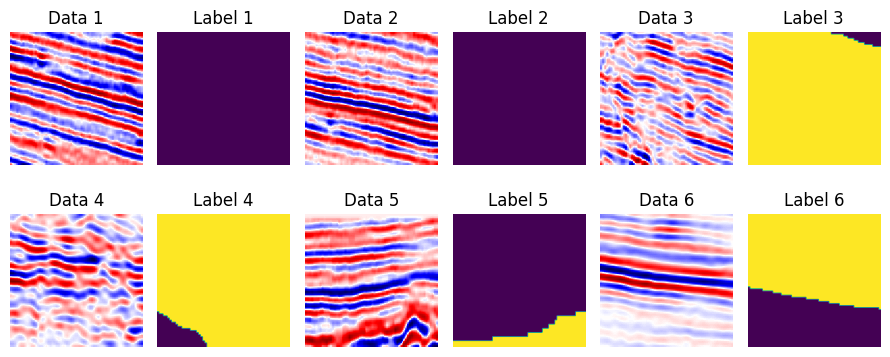

Testing SeismicDataset in windowed mode
(64, 64)
normalizing windows


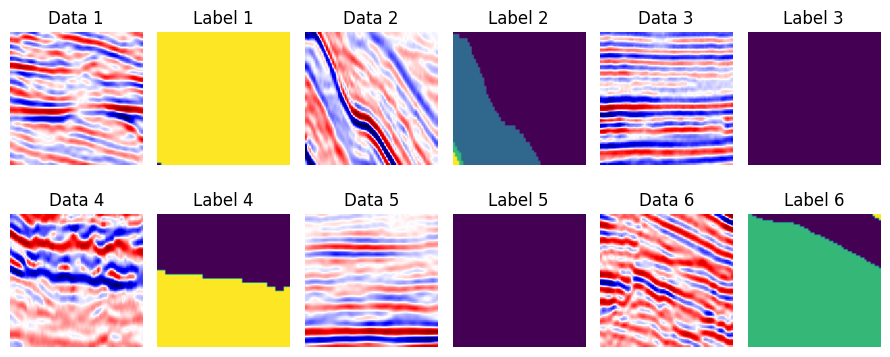

In [46]:
# dataset normalized only
windowed_dataset, windowed_dataloader = test_seismic_dataset_norm('windowed', norm_dl=False, norm_ds = True)
windowed_dataset, windowed_dataloader = test_seismic_dataset_norm('windowed', norm_dl=True, norm_ds = False)

Testing SeismicDataset in traces mode
(1006,)


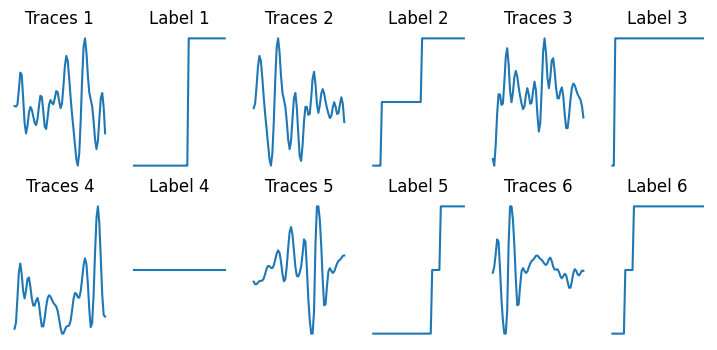

In [49]:
traces_dataset, traces_dataloader = test_seismic_dataset_norm('traces', norm_dl=True, norm_ds = False)

In [50]:
del original_dataset, original_dataloader, windowed_dataset, windowed_dataloader, traces_dataset, traces_dataloader

### Testing with ranges 

In [51]:
seam_path = {'train' : 'data/SEAM/seismic_train.npy', 'label' : 'data/SEAM/labels.npy', 'order' : ('z', 'x', 'y')}
f3_path = {'train' : 'data/F3/seismic_entire_volume.npy', 'label' : 'data/F3/labels_entire_volume.npy', 'order' : ('x', 'y', 'z')}
paths = [seam_path, f3_path]

In [52]:
# Full range (default behavior)
full_dataset = NpyDataset(paths)

In [53]:

# Using 50% of each dimension for both datasets
half_dataset = NpyDataset([
    {**seam_path, 'range': {'x': (0, 0.5), 'y': (0, 0.5)}},
    {**f3_path, 'range': {'x': (0, 0.5), 'y': (0, 0.5)}}
])


In [54]:
# Using different ranges for each dataset
mixed_dataset = NpyDataset([
    {**seam_path, 'range': {'x': (0.25, 0.75), 'y': (0, 1)}},  # Middle 50% of x, full y
    {**f3_path, 'range': {'x': (0, 1), 'y': (0.25, 0.75)}}    # Full x, middle 50% of y
])


In [55]:
print("Full dataset shapes: (z, x, y)")
print(f"SEAM: {full_dataset._get_shape(0, 'z')}, {full_dataset._get_shape(0, 'x')}, {full_dataset._get_shape(0, 'y')}")
print(f"F3: {full_dataset._get_shape(1, 'z')}, {full_dataset._get_shape(1, 'x')}, {full_dataset._get_shape(1, 'y')}")

Full dataset shapes: (z, x, y)
SEAM: 1006, 782, 590
F3: 255, 601, 901


In [56]:
print("Half dataset shapes: (z, x, y)")
print(f"SEAM: {half_dataset._get_shape(0, 'z')}, {half_dataset._get_shape(0, 'x')}, {half_dataset._get_shape(0, 'y')}")
print(f"F3: {half_dataset._get_shape(1, 'z')} ,{half_dataset._get_shape(1, 'x')}, {half_dataset._get_shape(1, 'y')}")

Half dataset shapes: (z, x, y)
SEAM: 1006, 391, 295
F3: 255 ,300, 450


In [57]:
print("Mixed dataset shapes: (z, x, y)")
print(f"SEAM: {mixed_dataset._get_shape(0, 'z')} ,{mixed_dataset._get_shape(0, 'x')}, {mixed_dataset._get_shape(0, 'y')}")
print(f"F3: {mixed_dataset._get_shape(1, 'z')}, {mixed_dataset._get_shape(1, 'x')}, {mixed_dataset._get_shape(1, 'y')}")

Mixed dataset shapes: (z, x, y)
SEAM: 1006 ,391, 590
F3: 255, 601, 450


In [58]:

def plot_dataset_slices(datasets, names):
    fig, axes = plt.subplots(len(datasets), 2, figsize=(6, 3*len(datasets)))
    if len(datasets) == 1:
        axes = axes.reshape(1, -1)
    
    for i, (dataset, name) in enumerate(zip(datasets, names)):
        seam_slice, _ = dataset[0]
        f3_slice, _ = dataset[dataset.n_items_per_file[0]]
        
        axes[i, 0].imshow(seam_slice, cmap='seismic')
        axes[i, 0].set_title(f"{name} - SEAM Slice")
        axes[i, 0].axis('on')
        
        axes[i, 1].imshow(f3_slice, cmap='seismic')
        axes[i, 1].set_title(f"{name} - F3 Slice")
        axes[i, 1].axis('on')
    
    plt.tight_layout()
    plt.show()

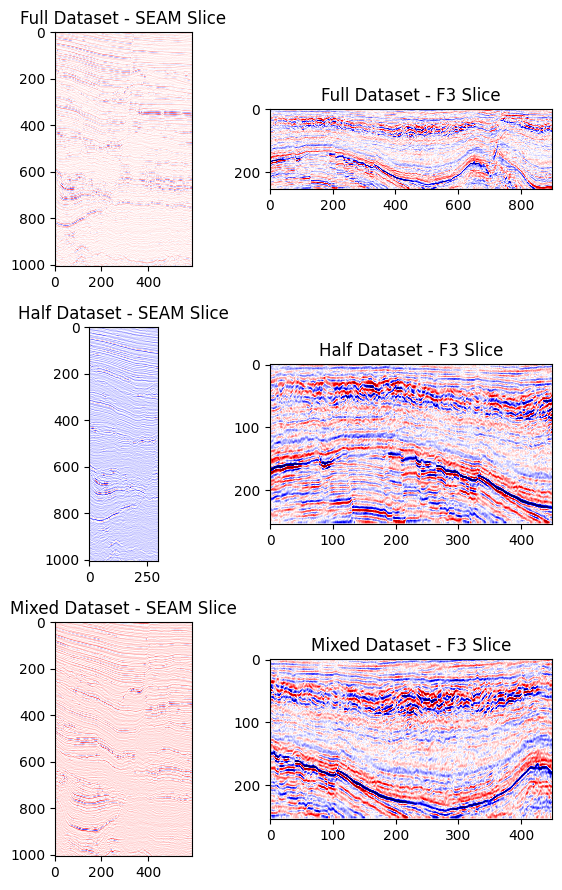

In [59]:
plot_dataset_slices([full_dataset, half_dataset, mixed_dataset], 
                    ["Full Dataset", "Half Dataset", "Mixed Dataset"])

In [60]:
del full_dataset, half_dataset, mixed_dataset

In [61]:
windowed_mixed_dataset = NpyDataset([
    {**seam_path, 'range': {'x': (0.25, 0.75), 'y': (0, 1)}},
    {**f3_path, 'range': {'x': (0, 1), 'y': (0.25, 0.75)}}
], mode='windowed', window_x=100, window_y=100, stride=30)

In [62]:
print(f"Windowed mixed dataset length: {len(windowed_mixed_dataset)}")

Windowed mixed dataset length: 478129


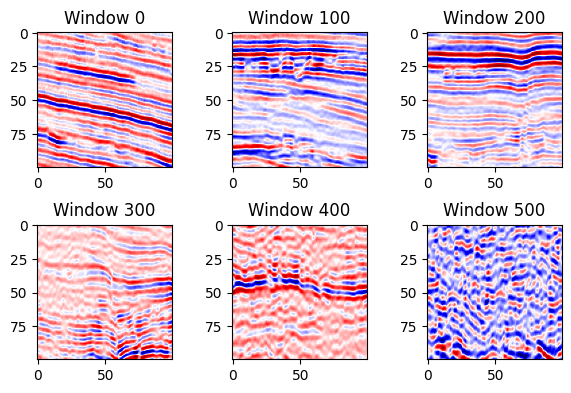

In [63]:
fig, axes = plt.subplots(2, 3, figsize=(6, 4))
for i in range(6):
    row = i // 3
    col = i % 3
    slice_data, _ = windowed_mixed_dataset[i * 100]
    axes[row, col].imshow(slice_data, cmap='seismic')
    axes[row, col].set_title(f"Window {i*100}")
    axes[row, col].axis('on')

plt.tight_layout()
plt.show()

In [64]:
windowed_mixed_dataloader = DataLoader(
    windowed_mixed_dataset, 
    batch_size=8, 
    shuffle=True, 
    collate_fn=windowed_mixed_dataset.create_windowed_collate_fn(
        windowed_mixed_dataset, 
        norm_flag=True, 
        window_x=64, 
        window_y=64, 
        stride=32
    )
)

In [65]:
batch_data, batch_labels = next(iter(windowed_mixed_dataloader))

normalizing windows


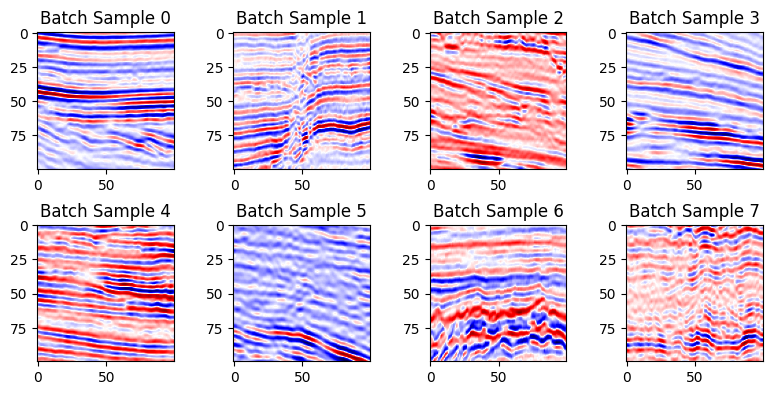

In [66]:
fig, axes = plt.subplots(2, 4, figsize=(8, 4))
for i in range(8):
    row = i // 4
    col = i % 4
    axes[row, col].imshow(batch_data[i].numpy(), cmap='seismic')
    axes[row, col].set_title(f"Batch Sample {i}")
    axes[row, col].axis('on')

plt.tight_layout()
plt.show()

In [67]:
print(f"Batch shape: {batch_data.shape}")

Batch shape: torch.Size([8, 100, 100])


In [68]:
del windowed_mixed_dataset, windowed_mixed_dataloader

### Saving and loading configuration 

In [69]:
seam_path = {'train' : 'data/SEAM/seismic_train.npy', 'label' : 'data/SEAM/labels.npy', 'order' : ('z', 'x', 'y')}
f3_path = {'train' : 'data/F3/seismic_entire_volume.npy', 'label' : 'data/F3/labels_entire_volume.npy', 'order' : ('x', 'y', 'z')}
paths = [seam_path, f3_path]

In [70]:
dataset = NpyDataset(paths, mode='windowed', window_x=128, window_y=128, stride=50)

In [71]:
# save config
p = 'dataset_metadata.json'
p = dataset.save_config(p)

{'paths': [{'train': 'data/SEAM/seismic_train.npy', 'label': 'data/SEAM/labels.npy', 'order': ('z', 'x', 'y')}, {'train': 'data/F3/seismic_entire_volume.npy', 'label': 'data/F3/labels_entire_volume.npy', 'order': ('x', 'y', 'z')}], 'dt_transformations': [], 'lb_transformations': [], 'dtype': 'float32', 'ltype': 'float32', 'norm': False, 'mode': 'windowed', 'window_x': 128, 'window_y': 128, 'stride': 50}


In [72]:
new_dataset = NpyDataset.from_config(p)